In [1]:
# analysis paper
# import libraries
import seaborn as sns
import numpy as np
import scipy.stats as _stats
from functools import reduce
from pipeline.analysis import *
from pipeline.utils import validate
from pipeline import *
import logging
import networkx as nx
import glob
from scipy.stats import sem as sem
from matplotlib import colormaps
import sys

# sys.path.insert(1, "/home/anna/Documents/code/python/pipeline")
from matplotlib.ticker import MaxNLocator
from rdkit import Chem
from copy import deepcopy

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

logging.getLogger().setLevel(logging.ERROR)


print(BSS.__file__)

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions


/home/anna/BioSimSpace/python/BioSimSpace/__init__.py


/home/anna/mambaforge/envs/pipeline/lib/python3.9/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
all_analysis_object = analysis_network(
    "/home/anna/Documents/benchmark/reruns/p38/outputs",
    exp_file=None,
    net_file="/home/anna/Documents/benchmark/reruns/p38/execution_model/network.dat",
)

ERROR:root:please set an experimental yml/csv file so this can be used, eg using .get_experimental(exp_file). 


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 │   all_analysis_object.perturbations,                                                       │
│   4 │   # ligands_folder="/home/anna/Documents/benchmark/inputs/industrybenchmarks2024/p38/l     │
│   5 )                                                                                            │
│ ❱ 6 graph.draw_graph()                                                                           │
│   7                                                                                              │
│                                                                                                  │
│ /home/anna/Documents/code/python/pipeline/analysis/_network.py:200 in draw_graph                 │
│                                                                                                  │
│   197 │   │   │   │   xa, ya = trans2((xx, yy))  # axes coordinates                              │
│   198 │   │   │   │   a = plt.axes([xa - p2, ya - p2, piesize, piesize])                         │
│   199 │   │   │   │   a.set_aspect("equal")                                                      │
│ ❱ 200 │   │   │   │   a.imshow(ImageOps.expand(                                                  │
│   201 │   │   │   │   │   graph.nodes[n]["image"], border=2, fill="black"))                      │
│   202 │   │   │   │   a.set_title(f"{n}", y=0.85)                                                │
│   203 │   │   │   │   a.axis("off")                                                              │
│                                                                                                  │
│ /home/anna/mambaforge/envs/pipeline/lib/python3.9/site-packages/PIL/ImageOps.py:432 in expand    │
│                                                                                                  │
│   429 │   :return: An image.                                                                     │
│   430 │   """                                                                                    │
│   431 │   left, top, right, bottom = _border(border)                                             │
│ ❱ 432 │   width = left + image.size[0] + right                                                   │
│   433 │   height = top + image.size[1] + bottom                                                  │
│   434 │   color = _color(fill, image.mode)                                                       │
│   435 │   if image.palette:                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'size'

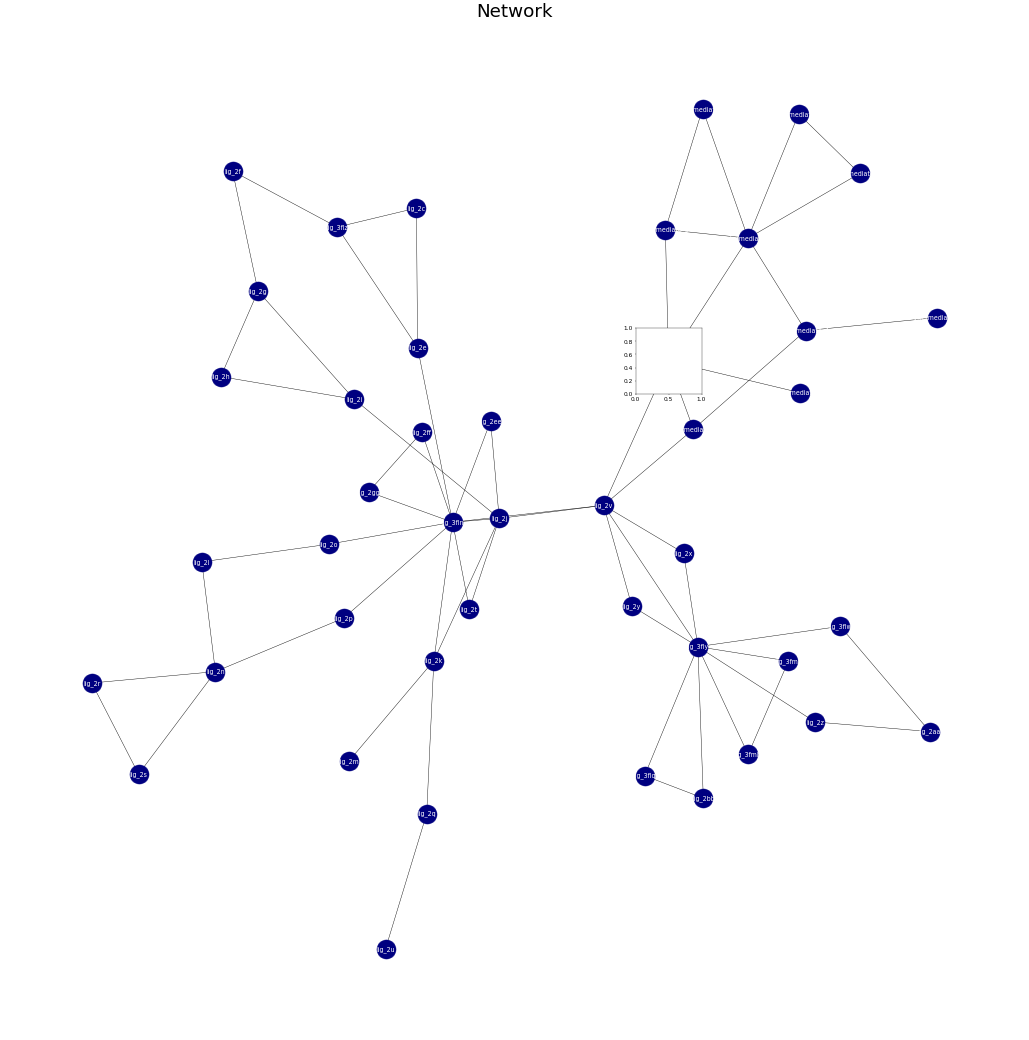

In [4]:
graph = network_graph(
    all_analysis_object.ligands,
    all_analysis_object.perturbations,
    # ligands_folder="/home/anna/Documents/benchmark/inputs/industrybenchmarks2024/p38/ligands_schroedinger22jacs_intermediates",
)
graph.draw_graph()

In [2]:
def write_perts_file(
    val_dict,
    file_path: str,
    eng: Optional[str] = None,
    analysis_string: Optional[str] = None,
    method: Optional[str] = None,
):
    val_dict = validate.dictionary(val_dict)

    if not method:
        method = "None"

    with open(f"{file_path}.csv", "w") as file:
        writer = csv.writer(file)
        writer.writerow(
            ["lig_0", "lig_1", "freenrg", "error", "engine", "analysis", "method"]
        )

        for key, value in val_dict.items():
            writer.writerow(
                [
                    key.split("~")[0],
                    key.split("~")[1],
                    value[0],
                    value[1],
                    eng,
                    analysis_string,
                    method,
                ]
            )

In [3]:
# define the analysis method to use
ana_dicts = {
    "plain": {
        "estimator": "MBAR",
        "method": "alchemlyb",
        "check overlap": True,
        "try pickle": True,
        "save pickle": True,
        "auto equilibration": False,
        "statistical inefficiency": False,
        "truncate lower": 0,
        "truncate upper": 100,
        "name": None,
    },
    "subsampling": {
        "estimator": "MBAR",
        "method": "alchemlyb",
        "check overlap": True,
        "try pickle": True,
        "save pickle": True,
        "auto equilibration": False,
        "statistical inefficiency": True,
        "truncate lower": 0,
        "truncate upper": 100,
        "name": None,
    },
    #     "1ns": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": True,
    #     "truncate lower": 0,
    #     "truncate upper": 25,
    #     "name": None,
    # },
    #     "2ns": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": True,
    #     "truncate lower": 0,
    #     "truncate upper": 50,
    #     "name": None,
    # },
    #     "3ns": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": True,
    #     "truncate lower": 0,
    #     "truncate upper": 75,
    #     "name": None,
    # },
    #     "autoeq": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": True,
    #     "statistical inefficiency": True,
    #     "truncate lower": 0,
    #     "truncate upper": 100,
    #     "name": None,
    # },
    # "TI": {
    # "estimator": "TI",
    # "method": "alchemlyb",
    # "check overlap": True,
    # "try pickle": True,
    # "save pickle": True,
    # "auto equilibration": False,
    # "statistical inefficiency": True,
    # "truncate lower": 0,
    # "truncate upper": 100,
    # "name": None,
    # },
    #     "single_0": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": False,
    #     "truncate lower": 0,
    #     "truncate upper": 100,
    #     "name": None,
    # },
    #     "single_1": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": False,
    #     "truncate lower": 0,
    #     "truncate upper": 100,
    #     "name": None,
    # },
    #     "single_2": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": False,
    #     "truncate lower": 0,
    #     "truncate upper": 100,
    #     "name": None,
    # }
}

In [30]:
# set the variables
network = "lomap"  # lomap rbfenn combined

prot_dict_name = {
    "tyk2": "TYK2",
    "mcl1": "MCL1",
    "p38": "P38α",
    "syk": "SYK",
    "hif2a": "HIF2A",
    "cmet": "CMET",
}
eng_dict_name = {"AMBER": "AMBER22", "SOMD": "SOMD1", "GROMACS": "GROMACS23"}

# all the options
ana_obj_dict = {}

for protein in ["tyk2", "mcl1", "p38", "syk", "hif2a", "cmet"]:
    ana_obj_dict[protein] = {}

    for ana_dict in ana_dicts:
        ana_prot = analysis_protocol(ana_dicts[ana_dict])
        print(protein, ana_dict)

        if protein == "syk" or protein == "cmet":
            main_dir = f"/backup/{protein}/neutral"
        else:
            main_dir = f"/backup/{protein}"

        bench_folder = f"/home/anna/Documents/benchmark"

        # if need size of protein
        try:
            prot = BSS.IO.readMolecules(
                [
                    f"{bench_folder}/inputs/{protein}/{protein}_prep/{protein}.gro",
                    f"{bench_folder}/inputs/{protein}/{protein}_prep/{protein}.top",
                ]
            )[0]
        except:
            prot = BSS.IO.readMolecules(
                [
                    f"{bench_folder}/inputs/{protein}/{protein}_parameterised.prm7",
                    f"{bench_folder}/inputs/{protein}/{protein}_parameterised.rst7",
                ]
            )[0]

        print(f"no of residues in the protein: {prot.nResidues()}")

        # choose location for the files
        if protein == "syk" or protein == "cmet" or protein == "hif2a":
            # the lomap network
            net_file = f"{main_dir}/execution_model/network_all.dat"
        else:
            net_file = f"{main_dir}/execution_model/network_{network}.dat"

        exp_file = f"{bench_folder}/inputs/experimental/{protein}.yml"
        output_folder = f"{main_dir}/outputs_extracted"

        # prot_file = f"{main_dir}/execution_model/protocol.dat" # no protocol used , name added after if needed
        pipeline_prot = pipeline_protocol(auto_validate=True)
        # pipeline_prot.name("")

        # initialise the network object
        all_analysis_object = analysis_network(
            output_folder,
            exp_file=exp_file,
            net_file=net_file,
            analysis_prot=ana_prot,
            method=pipeline_prot.name(),  # if the protocol had a name
            engines=pipeline_prot.engines(),
        )

        # compute
        all_analysis_object.compute_results()

        if ana_dict == "single":
            all_analysis_object.file_ext = all_analysis_object.file_ext + f"_{ana_dict}"

        # add ligands folder
        if os.path.isdir(f"{bench_folder}/inputs/{protein}/ligands"):
            all_analysis_object.add_ligands_folder(
                f"{bench_folder}/inputs/{protein}/ligands"
            )
        else:
            all_analysis_object.add_ligands_folder(
                f"{bench_folder}/inputs/{protein}/ligands_neutral"
            )

        ana_obj_dict[protein][ana_dict] = all_analysis_object

print(ana_obj_dict)

ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...


tyk2 plain


ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x7515881e7760> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...


no of residues in the protein: 290


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...


tyk2 subsampling


ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x75158830e7f0> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...


no of residues in the protein: 290


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...


mcl1 plain


ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x7515706d91c0> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...


no of residues in the protein: 153


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'lig_40'
ERROR:root:lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_40'
ERROR:root:lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_40'
ERROR:root:lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_40'
ERROR:root:lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_27~lig_43'
ERROR:root:lig_27~lig_43 not in both dicts, GROMACS and calc
ERROR:root:'lig_40'
E

mcl1 subsampling


ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x75157070b7c0> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...


no of residues in the protein: 153


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'lig_40'
ERROR:root:lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_40'
ERROR:root:lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_40'
ERROR:root:lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_43~lig_27'
ERROR:root:lig_43~lig_27 not in both dicts, AMBER and calc
ERROR:root:'lig_40'
ERROR:root:lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_27~lig_43'
ERROR:root:lig_27~lig_43 not in both dicts, GROMACS and calc
ERROR:root:'lig_40'
E

p38 plain


ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x75157074ba00> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...


no of residues in the protein: 351


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2a~lig_2h'
ERROR:root:lig_2a~lig_2h not in both dicts, GROMACS and calc
ERROR:root:'lig_2a~lig_2h'
ERROR:root:lig_2a~lig_2h not in both dicts, GROMACS and calc
ERROR:root:'lig_2a~lig_2h'
ERROR:root:lig_2a~lig_2h not in both dicts, GROMACS and calc
ERROR:root:'lig_2a~lig_2h'
ERROR:root:lig_2a~lig_2h not in both dicts, SOMD and calc
ERROR:root:'lig_2a~lig_2h'
ERROR:root:lig_2a~lig

p38 subsampling


ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x7515c0235f70> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...


no of residues in the protein: 351


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2h~lig_2a'
ERROR:root:lig_2h~lig_2a not in both dicts, AMBER and calc
ERROR:root:'lig_2a~lig_2h'
ERROR:root:lig_2a~lig_2h not in both dicts, GROMACS and calc
ERROR:root:'lig_2a~lig_2h'
ERROR:root:lig_2a~lig_2h not in both dicts, GROMACS and calc
ERROR:root:'lig_2a~lig_2h'
ERROR:root:lig_2a~lig_2h not in both dicts, GROMACS and calc
ERROR:root:'lig_2a~lig_2h'
ERROR:root:lig_2a~lig_2h not in both dicts, SOMD and calc
ERROR:root:'lig_2a~lig_2h'
ERROR:root:lig_2a~lig

syk plain


ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x75157074ba00> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...
ERROR:root:the graph is not connected. some perturbations failed? proceeding w the largest graph for the cinnabar anlysis...
ERROR:root:proceeding with ['lig_1', 'lig_10', 'lig_11', 'lig_16', 'lig_17', 'lig_18', 'lig_19', 'lig_2', 'lig_20', 'lig_23', 'lig_24', 'lig_25', 'lig_26', 'lig_27', 'lig_28', 'lig_29', 'lig_3', 'lig_30', 'lig_31', 'lig_33', 'lig_34', 'lig_35', 'lig_36', 'lig_38', 'lig_39', 'lig_4', 'lig_40', 'lig_41', 'lig_42', 'lig_44', 'lig_5', 'lig_6', 'lig_7', 'lig_9'] and ['lig_1~lig_41', 'lig_10~lig_17', 'lig_10~lig_9', 'lig_10~lig_5', 'lig_10~lig_16', 'lig_10~lig_3', 'lig_10~lig_34', 'lig_10~lig_24', 'lig_10~lig_42', 'lig_11~lig_5', 'lig_11~lig_34', 'lig_11~l

no of residues in the protein: 277
Graph is not connected enough to compute absolute values


ERROR:root:the graph is not connected. some perturbations failed? proceeding w the largest graph for the cinnabar anlysis...
ERROR:root:proceeding with ['lig_1', 'lig_10', 'lig_11', 'lig_16', 'lig_17', 'lig_18', 'lig_19', 'lig_2', 'lig_20', 'lig_23', 'lig_24', 'lig_25', 'lig_26', 'lig_27', 'lig_28', 'lig_29', 'lig_3', 'lig_30', 'lig_31', 'lig_33', 'lig_34', 'lig_35', 'lig_36', 'lig_38', 'lig_39', 'lig_4', 'lig_40', 'lig_41', 'lig_42', 'lig_44', 'lig_5', 'lig_6', 'lig_7', 'lig_9'] and ['lig_1~lig_41', 'lig_10~lig_17', 'lig_10~lig_9', 'lig_10~lig_5', 'lig_10~lig_16', 'lig_10~lig_3', 'lig_10~lig_34', 'lig_10~lig_24', 'lig_10~lig_42', 'lig_11~lig_5', 'lig_11~lig_34', 'lig_11~lig_18', 'lig_11~lig_42', 'lig_16~lig_9', 'lig_16~lig_17', 'lig_16~lig_18', 'lig_16~lig_3', 'lig_19~lig_40', 'lig_19~lig_25', 'lig_2~lig_20', 'lig_2~lig_30', 'lig_20~lig_30', 'lig_23~lig_24', 'lig_23~lig_42', 'lig_25~lig_29', 'lig_26~lig_6', 'lig_26~lig_36', 'lig_27~lig_44', 'lig_27~lig_38', 'lig_28~lig_35', 'lig_28~li

Graph is not connected enough to compute absolute values


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'lig_26'
ERROR:root:lig_26 not in both dicts, AMBER and calc
ERROR:root:'lig_36'
ERROR:root:lig_36 not in both dicts, AMBER and calc
ERROR:root:'lig_13'
ERROR:root:lig_13 not in both dicts, AMBER and calc
ERROR:root:'lig_37'
ERROR:root:lig_37 not in both dicts, AMBER and calc
ERROR:root:'lig_8'
ERROR:root:lig_8 not in both dicts, AMBER and calc
ERROR:root:'lig_21'
ERROR:root:lig_21 not in both dicts, AMBER and calc
ERROR:root:'lig_42~lig_40'
ERROR:root:lig_42~lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_6~lig_40'
ERROR:root:lig_6~lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_29~lig_25'
ERROR:root:lig_29~lig_25 not in both dicts, AMBER and calc
ERROR:root:'lig_6~lig_26'
ERROR:root:lig_6~lig_26 not in both dicts, AMBER and calc
ERROR:root:'lig_6~lig_36'
ERROR:root:lig_6~lig_36 not in both dicts, AMBER and calc
ERROR:root:'lig_44~lig_27'
ERROR:root:lig_44~lig_27 not in 

syk subsampling


ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x7516b5395040> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...
ERROR:root:the graph is not connected. some perturbations failed? proceeding w the largest graph for the cinnabar anlysis...
ERROR:root:proceeding with ['lig_1', 'lig_10', 'lig_11', 'lig_16', 'lig_17', 'lig_18', 'lig_19', 'lig_2', 'lig_20', 'lig_23', 'lig_24', 'lig_25', 'lig_26', 'lig_27', 'lig_28', 'lig_29', 'lig_3', 'lig_30', 'lig_31', 'lig_33', 'lig_34', 'lig_35', 'lig_36', 'lig_38', 'lig_39', 'lig_4', 'lig_40', 'lig_41', 'lig_42', 'lig_44', 'lig_5', 'lig_6', 'lig_7', 'lig_9'] and ['lig_1~lig_41', 'lig_10~lig_17', 'lig_10~lig_9', 'lig_10~lig_5', 'lig_10~lig_16', 'lig_10~lig_3', 'lig_10~lig_34', 'lig_10~lig_24', 'lig_10~lig_42', 'lig_11~lig_5', 'lig_11~lig_34', 'lig_11~l

no of residues in the protein: 277
Graph is not connected enough to compute absolute values


ERROR:root:the graph is not connected. some perturbations failed? proceeding w the largest graph for the cinnabar anlysis...
ERROR:root:proceeding with ['lig_1', 'lig_10', 'lig_11', 'lig_16', 'lig_17', 'lig_18', 'lig_19', 'lig_2', 'lig_20', 'lig_23', 'lig_24', 'lig_25', 'lig_26', 'lig_27', 'lig_28', 'lig_29', 'lig_3', 'lig_30', 'lig_31', 'lig_33', 'lig_34', 'lig_35', 'lig_36', 'lig_38', 'lig_39', 'lig_4', 'lig_40', 'lig_41', 'lig_42', 'lig_44', 'lig_5', 'lig_6', 'lig_7', 'lig_9'] and ['lig_1~lig_41', 'lig_10~lig_17', 'lig_10~lig_9', 'lig_10~lig_5', 'lig_10~lig_16', 'lig_10~lig_3', 'lig_10~lig_34', 'lig_10~lig_24', 'lig_10~lig_42', 'lig_11~lig_5', 'lig_11~lig_34', 'lig_11~lig_18', 'lig_11~lig_42', 'lig_16~lig_9', 'lig_16~lig_17', 'lig_16~lig_18', 'lig_16~lig_3', 'lig_19~lig_40', 'lig_19~lig_25', 'lig_2~lig_20', 'lig_2~lig_30', 'lig_20~lig_30', 'lig_23~lig_24', 'lig_23~lig_42', 'lig_25~lig_29', 'lig_26~lig_6', 'lig_26~lig_36', 'lig_27~lig_44', 'lig_27~lig_38', 'lig_28~lig_35', 'lig_28~li

Graph is not connected enough to compute absolute values


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'lig_26'
ERROR:root:lig_26 not in both dicts, AMBER and calc
ERROR:root:'lig_36'
ERROR:root:lig_36 not in both dicts, AMBER and calc
ERROR:root:'lig_13'
ERROR:root:lig_13 not in both dicts, AMBER and calc
ERROR:root:'lig_37'
ERROR:root:lig_37 not in both dicts, AMBER and calc
ERROR:root:'lig_8'
ERROR:root:lig_8 not in both dicts, AMBER and calc
ERROR:root:'lig_21'
ERROR:root:lig_21 not in both dicts, AMBER and calc
ERROR:root:'lig_42~lig_40'
ERROR:root:lig_42~lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_6~lig_40'
ERROR:root:lig_6~lig_40 not in both dicts, AMBER and calc
ERROR:root:'lig_29~lig_25'
ERROR:root:lig_29~lig_25 not in both dicts, AMBER and calc
ERROR:root:'lig_6~lig_26'
ERROR:root:lig_6~lig_26 not in both dicts, AMBER and calc
ERROR:root:'lig_6~lig_36'
ERROR:root:lig_6~lig_36 not in both dicts, AMBER and calc
ERROR:root:'lig_44~lig_27'
ERROR:root:lig_44~lig_27 not in 

hif2a plain
no of residues in the protein: 112


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, AMBER and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, AMBER and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, AMBER and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, AMBER and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, GROMACS and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, SOMD and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, experimental and calc
ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x7515d009c3a0> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipe

hif2a subsampling
no of residues in the protein: 112


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, AMBER and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, AMBER and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, AMBER and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, AMBER and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, GROMACS and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, SOMD and calc
ERROR:root:'lig_9'
ERROR:root:lig_9 not in both dicts, experimental and calc
ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...


cmet plain


ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x7516b5109f10> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...


no of residues in the protein: 286


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'lig_9~lig_7'
ERROR:root:lig_9~lig_7 not in both dicts, AMBER and calc
ERROR:root:'lig_10~lig_1'
ERROR:root:lig_10~lig_1 not in both dicts, AMBER and calc
ERROR:root:'lig_17~lig_1'
ERROR:root:lig_17~lig_1 not in both dicts, AMBER and calc
ERROR:root:'lig_7~lig_18'
ERROR:root:lig_7~lig_18 not in both dicts, AMBER and calc
ERROR:root:'lig_9~lig_7'
ERROR:root:lig_9~lig_7 not in both dicts, AMBER and calc
ERROR:root:'lig_10~lig_1'
ERROR:root:lig_10~lig_1 not in both dicts, AMBER and calc
ERROR:root:'lig_17~lig_1'
ERROR:root:lig_17~lig_1 not in both dicts, AMBER and calc
ERROR:root:'lig_7~lig_18'
ERROR:root:lig_7~lig_18 not in both dicts, AMBER and calc
ERROR:root:'lig_9~lig_7'
ERROR:root:lig_9~lig_7 not in both dicts, AMBER and calc
ERROR:root:'lig_10~lig_1'
ERROR:root:lig_10~lig_1 not in both dicts, AMBER and calc
ERROR:root:'lig_17~lig_1'
ERROR:root:lig_17~lig_1 not in both dicts, AMBER and 

cmet subsampling


ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x7515883fc7c0> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...


no of residues in the protein: 286


ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:trhing free bound
ERROR:root:'lig_9~lig_7'
ERROR:root:lig_9~lig_7 not in both dicts, AMBER and calc
ERROR:root:'lig_10~lig_1'
ERROR:root:lig_10~lig_1 not in both dicts, AMBER and calc
ERROR:root:'lig_17~lig_1'
ERROR:root:lig_17~lig_1 not in both dicts, AMBER and calc
ERROR:root:'lig_7~lig_18'
ERROR:root:lig_7~lig_18 not in both dicts, AMBER and calc
ERROR:root:'lig_9~lig_7'
ERROR:root:lig_9~lig_7 not in both dicts, AMBER and calc
ERROR:root:'lig_10~lig_1'
ERROR:root:lig_10~lig_1 not in both dicts, AMBER and calc
ERROR:root:'lig_17~lig_1'
ERROR:root:lig_17~lig_1 not in both dicts, AMBER and calc
ERROR:root:'lig_7~lig_18'
ERROR:root:lig_7~lig_18 not in both dicts, AMBER and calc
ERROR:root:'lig_9~lig_7'
ERROR:root:lig_9~lig_7 not in both dicts, AMBER and calc
ERROR:root:'lig_10~lig_1'
ERROR:root:lig_10~lig_1 not in both dicts, AMBER and calc
ERROR:root:'lig_17~lig_1'
ERROR:root:lig_17~lig_1 not in both dicts, AMBER and 

{'tyk2': {'plain': <pipeline.analysis._analysis_network.analysis_network object at 0x7515c06a9610>, 'subsampling': <pipeline.analysis._analysis_network.analysis_network object at 0x75158836af10>}, 'mcl1': {'plain': <pipeline.analysis._analysis_network.analysis_network object at 0x75158836a790>, 'subsampling': <pipeline.analysis._analysis_network.analysis_network object at 0x7515707320a0>}, 'p38': {'plain': <pipeline.analysis._analysis_network.analysis_network object at 0x75157064c550>, 'subsampling': <pipeline.analysis._analysis_network.analysis_network object at 0x75157070b7c0>}, 'syk': {'plain': <pipeline.analysis._analysis_network.analysis_network object at 0x7515c04a35b0>, 'subsampling': <pipeline.analysis._analysis_network.analysis_network object at 0x7515c0235f70>}, 'hif2a': {'plain': <pipeline.analysis._analysis_network.analysis_network object at 0x7517239b3850>, 'subsampling': <pipeline.analysis._analysis_network.analysis_network object at 0x7516b5395d30>}, 'cmet': {'plain': <p

In [ ]:
# check maximum possible accuracy
r2_dict = {}
r2_error_dict = {}
for prot in ana_obj_dict.keys():
    r2_dict[prot] = {}
    r2_error_dict[prot] = {}
    ana_obj = ana_obj_dict[prot]["plain"]
    print(prot, len(ana_obj.ligands))
    print(
        "max",
        max(ana_obj.exper_val_dict.values())[0],
        "min",
        min(ana_obj.exper_val_dict.values())[0],
        "range",
        max(ana_obj.exper_val_dict.values())[0]
        - min(ana_obj.exper_val_dict.values())[0],
    )
    avg = np.mean([val[1] for val in ana_obj.exper_val_dict.values()])
    std = np.std([val[0] for val in ana_obj.exper_val_dict.values()])
    print("mean of error", avg, "std of val", std)
    # experimental uncertainty is std of measurement error
    # max is measurement error / std dev of the affinity , squared
    # tyk2 mcl1 Ki 0.44
    # others IC50 0.75
    r2max = 1 - (avg / std) ** 2
    print(r2max)
    r2_dict[prot]["maximum"] = r2max
    r2_error_dict[prot]["maximum"] = (0, 0)

In [ ]:
# exclude outliers
threshold = 10
for prot in ana_obj_dict.keys():
    for name in ana_dicts.keys():
        print(prot, name)
        ana_obj = ana_obj_dict[prot][name]

        for eng in ana_obj.engines:
            ana_obj.file_ext = ana_obj.file_ext + f"_outliers{threshold}removed"
            ana_obj.remove_outliers(threshold=threshold, name=eng)
        # print(ana_obj.file_ext)

In [81]:
prot = "mcl1"
lig = "lig_45"
ana_obj = ana_obj_dict[prot]["subsampling"]
for pert in ana_obj.perturbations:
    if lig in pert:
        print(pert)
        for eng in ana_obj.engines:
            print(eng, ana_obj.calc_pert_dict[eng][pert])
        print("exp", ana_obj.exper_pert_dict[pert])
        ana_obj.remove_perturbations([pert])

In [ ]:
mae = ana_obj.calc_kendalls_rank_engines(pert_val="val", recalculate=True)

for eng in ana_obj.engines:
    print(f"{eng} MAE: {mae[0][eng]['experimental']:.2f} {mae[2][eng]['experimental']}")

In [61]:
# write ligands seperately

mols = Chem.SDMolSupplier(
    "/home/anna/Documents/benchmark/inputs/industrybenchmarks2024/p38/schroedinger22jacs_ligands.sdf"
)
for mol in mols:
    # print(mol.GetProp("_Name"))
    with Chem.SDWriter(
        f'/home/anna/Documents/benchmark/inputs/industrybenchmarks2024/p38/ligands_schroedinger22jacs_intermediates/lig_{mol.GetProp("_Name").replace("p38a_","").replace("_","")}.sdf'
    ) as w:
        w.write(mol)

In [31]:
# rename
name_dict = {}
for prot in ["syk", "hif2a", "cmet"]:
    jacs_file = f"/home/anna/Documents/benchmark/inputs/{prot}/results_edges_5ns.csv"
    mols = Chem.SDMolSupplier(
        f"/home/anna/Documents/benchmark/inputs/{prot}/ligands.sdf"
    )
    name_dict[prot] = {}
    for mol, idx in zip(mols, range(1, len(mols) + 1, 1)):
        name_dict[prot][mol.GetProp("_Name")] = f"lig_{idx}"

In [32]:
# compared to shroedinger results

jacs_file = "/home/anna/Documents/benchmark/inputs/jacs2015_inputs/jacs2015results.csv"
jacs_df = pd.read_csv(jacs_file)
# jacs_df

jacs_dict = {}  # convert into a dictionary of values

for prot in ["Tyk2", "MCL1", "P38"]:
    jacs_dict[prot.lower()] = {}
    for index, row in jacs_df.iterrows():
        if row["system"].upper() == prot.upper():
            jacs_dict[prot.lower()][f"{row['Ligand1']}~{row['Ligand2']}"] = (
                row["bennett_ddG"],
                row["bennett_error"],
            )

for prot in ["syk", "hif2a", "cmet"]:
    jacs_file = f"/home/anna/Documents/benchmark/inputs/{prot}/results_edges_5ns.csv"
    jacs_df = pd.read_csv(jacs_file)
    jacs_dict[prot.lower()] = {}
    for index, row in jacs_df.iterrows():
        jacs_dict[prot.lower()][
            f"{name_dict[prot][row['Ligand1']]}~{name_dict[prot][row['Ligand2']]}"
        ] = (row["FEP"], row["FEP Error"])


# exper dict - these are slightly diff in the fepplus outputs
exper_dict_missing = {}
fep_lig_dict = {}

jacs_file = (
    "/home/anna/Documents/benchmark/inputs/jacs2015_inputs/jacs2015resultsdG.csv"
)
jacs_df = pd.read_csv(jacs_file, delimiter=",")

for prot in ["Tyk2", "MCL1", "P38"]:
    exper_dict_missing[prot.lower()] = {}
    fep_lig_dict[prot.lower()] = {}
    for index, row in jacs_df.iterrows():
        if row["Systems"].upper() == prot.upper():
            try:
                exper_dict_missing[prot.lower()][row["Ligand"]] = (row["Exp. dG"], 0.44)
                fep_lig_dict[prot.lower()][row["Ligand"]] = (
                    row["Pred. dG"],
                    row["Pred. Error"],
                )
            except:
                print(row["Ligand"])

for prot in ["syk", "hif2a", "cmet"]:
    jacs_file = f"/home/anna/Documents/benchmark/inputs/{prot}/results_5ns.csv"
    jacs_df = pd.read_csv(jacs_file, delimiter=",")
    exper_dict_missing[prot] = {}
    fep_lig_dict[prot] = {}
    for index, row in jacs_df.iterrows():
        try:
            exper_dict_missing[prot][name_dict[prot][row["Ligand"]]] = (
                row["Exp. ΔG"],
                0.44,
            )
            fep_lig_dict[prot][name_dict[prot][row["Ligand"]]] = (
                row["Pred. ΔG"],
                row["Pred. Error"],
            )
        except:
            print(row["Ligand"])


# for cinnabar files
for prot in ana_obj_dict.keys():
    write_perts_file(
        jacs_dict[prot],
        file_path=f"/home/anna/Documents/benchmark/inputs/{prot}/perts_file_fepplus",  # .csv
    )

In [6]:
# set protein and ana_obj
prot = "tyk2"
ana_obj = ana_obj_dict[prot]["subsampling"]

In [45]:
# professa results

file = f"/home/anna/Documents/benchmark/inputs/other_computed/professa/professa_{prot}_results.dat"

df = pd.read_csv(file, delimiter=",")

perts_dict = {}
for index, row in df.iterrows():
    perts_dict[f"{row['perturbation']}"] = (float(row["ddG"]), float(row["ddG_error"]))
write_perts_file(
    perts_dict,
    # .csv
    file_path=f"/home/anna/Documents/benchmark/inputs/{prot}/perts_file_professa",
)

In [51]:
# hahn et al
file = f"/home/anna/Documents/benchmark/inputs/other_computed/hahn_{prot}_kjmol.dat"

df = pd.read_csv(file, delimiter=",")

perts_dict = {}
for index, row in df.iterrows():
    perts_dict[f"{row['perturbation']}"] = (float(row["ddG"]), float(row["ddG_error"]))

# need to convert into kcal/mol
for key in perts_dict:
    perts_dict[key] = (perts_dict[key][0] * 0.239006, perts_dict[key][1] * 0.239006)

write_perts_file(
    perts_dict,
    # .csv
    file_path=f"/home/anna/Documents/benchmark/inputs/{prot}/perts_file_hahn",
)

In [52]:
# which of the additional data
name = "hahn"

files = [f"/home/anna/Documents/benchmark/inputs/{prot}/perts_file_{name}.csv"]

calc_diff_dict = make_dict.comp_results(files)  # older method

perts, ligs = get_info_network_from_dict(calc_diff_dict)

if name == "fepplus":
    exper_dict = exper_dict_missing[prot]
elif name == "hahn":
    exper_dict = pipeline.analysis.convert.yml_into_exper_dict(
        exp_file=ana_obj.exp_file, temperature=298
    )
else:
    exper_dict = ana_obj.exper_val_dict

convert.cinnabar_file(
    files,
    exper_dict,
    f"/home/anna/Documents/benchmark/inputs/{prot}/cinnabar_{name}",
    perturbations=perts,
    method=None,
)

# compute the per ligand for the network
network = wrangle.FEMap(
    f"/home/anna/Documents/benchmark/inputs/{prot}/cinnabar_{name}.csv"
)

# for self plotting of per ligand
cinnabar_calc_val_dict = make_dict.from_cinnabar_network_node(network, "calc")
cinnabar_calc_pert_dict = make_dict.from_cinnabar_network_edges(network, "calc", perts)

# normalise exper dict
normalised_exper_dict = {}
avg = np.mean([val[0] for val in exper_dict.values()])
for lig in exper_dict:
    normalised_exper_dict[lig] = (exper_dict[lig][0] - avg, exper_dict[lig][1])

x = []
y = []
xerr = []
yerr = []
for lig in ligs:
    if not np.isnan(cinnabar_calc_val_dict[lig][0]):
        x.append(cinnabar_calc_val_dict[lig][0])
        xerr.append(cinnabar_calc_val_dict[lig][1])
        y.append(normalised_exper_dict[lig][0])
        yerr.append(normalised_exper_dict[lig][1])

In [ ]:
# calculate the stats for the additional data
# print(x,y,xerr,yerr)
res = stats_engines.compute_stats(x=x, xerr=xerr, y=y, yerr=yerr, statistic="R2")
print("MAE cinnabar", prot, res)

In [ ]:
# compute RMSE of perturbations
exper_pert_dict = pipeline.analysis.make_dict.exper_from_perturbations(
    exper_dict, perts
)

x = []
y = []
xerr = []
yerr = []
for lig in perts:
    if not np.isnan(cinnabar_calc_pert_dict[lig][0]):
        x.append(cinnabar_calc_pert_dict[lig][0])
        xerr.append(cinnabar_calc_pert_dict[lig][1])
        y.append(exper_pert_dict[lig][0])
        yerr.append(exper_pert_dict[lig][1])

res = stats_engines.compute_stats(x=x, xerr=xerr, y=y, yerr=yerr, statistic="RMSE")
print("RMSE", prot, res)

In [59]:
# iteratively for the different fepplus result protein files
statistic = "R2"  # R2, MUE, KTAU
only_same_ligands = True  # looking only at the ligands that are the same
only_perturbations_with_same_ligands = (
    False  # keeping only perturbations that also include these ligands
)

cinnabar_dicts = {}
for prot in ana_obj_dict.keys():
    ana_obj = ana_obj_dict[prot]["subsampling"]

    files = [f"/home/anna/Documents/benchmark/inputs/{prot}/perts_file_fepplus.csv"]

    calc_diff_dict = make_dict.comp_results(files)  # older method

    perts, ligs = get_info_network_from_dict(calc_diff_dict)
    # print(len(perts))

    exper_dict = deepcopy(exper_dict_missing[prot])
    # ana_obj.exper_val_dict = exper_dict_missing[prot]
    normalised_exper_dict = {}
    avg = np.mean([val[0] for val in exper_dict.values()])
    removed_ligs = []
    for lig in list(exper_dict.keys()):
        if only_same_ligands:
            if lig in ana_obj.ligands:
                normalised_exper_dict[lig] = (
                    exper_dict[lig][0] - avg,
                    exper_dict[lig][1],
                )
            else:
                ligs.remove(lig)
                if only_perturbations_with_same_ligands:
                    exper_dict.pop(lig)
                print(f"removed {lig}")
                removed_ligs.append(lig)
        else:
            normalised_exper_dict[lig] = (exper_dict[lig][0] - avg, exper_dict[lig][1])
    # ana_obj.normalised_exper_val_dict = normalised_exper_dict

    if only_perturbations_with_same_ligands:
        old_perts = deepcopy(perts)
        perts = []
        for pert in old_perts:
            lig0 = pert.split("~")[0]
            lig1 = pert.split("~")[1]
            if lig0 not in ligs or lig1 not in ligs:
                print(f"removed {pert}")
            else:
                perts.append(pert)
    # print(len(perts))
    # ana_obj._initialise_stats_object(check=False)

    convert.cinnabar_file(
        [f"/home/anna/Documents/benchmark/inputs/{prot}/perts_file_fepplus.csv"],
        exper_dict,
        f"/home/anna/Documents/benchmark/inputs/{prot}/cinnabar",
        perturbations=perts,
        method=None,
    )
    print(f"/home/anna/Documents/benchmark/inputs/{prot}/cinnabar")

    # compute the per ligand for the network
    network = wrangle.FEMap(
        f"/home/anna/Documents/benchmark/inputs/{prot}/cinnabar.csv"
    )

    # for self plotting of per ligand
    cinnabar_calc_val_dict = make_dict.from_cinnabar_network_node(network, "calc")
    cinnabar_dicts[prot] = cinnabar_calc_val_dict

    x = []
    y = []
    xdata = []
    ydata = []
    xerr = []
    yerr = []
    xerrdata = []
    yerrdata = []
    print(len(ligs))
    print(len(cinnabar_calc_val_dict.keys()))
    for lig in ligs:
        try:
            if not np.isnan(cinnabar_calc_val_dict[lig][0]):
                x.append(cinnabar_calc_val_dict[lig][0])
                xerr.append(cinnabar_calc_val_dict[lig][1])
                xdata.append(fep_lig_dict[prot][lig][0])
                xerrdata.append(fep_lig_dict[prot][lig][1])
                y.append(normalised_exper_dict[lig][0])
                yerr.append(normalised_exper_dict[lig][1])
                ydata.append(exper_dict[lig][0])
                yerrdata.append(exper_dict[lig][1])
        except:
            pass

    # print(x,y,xerr,yerr)
    # res = stats_engines.compute_stats(x=x, xerr=xerr,
    #                                     y=y, yerr=yerr,
    #                                     statistic=statistic)
    # print(statistic, "cinnabar", prot, res)
    # for the values from the files, not computed with cinnabar
    res = stats_engines.compute_stats(
        x=xdata, xerr=xerrdata, y=ydata, yerr=yerrdata, statistic=statistic
    )
    print(statistic, "cc", prot, res)

/home/anna/Documents/benchmark/inputs/tyk2/cinnabar
16
16
R2 cc tyk2 (0.7939844612994295, 0.10445125170702096, [0.5424932839429345, 0.9460521531762885])
removed lig_39
removed lig_41
removed lig_51
removed lig_54
removed lig_57
removed lig_62
removed lig_64
removed lig_66
removed lig_68
/home/anna/Documents/benchmark/inputs/mcl1/cinnabar
33
42
R2 cc mcl1 (0.6211177559825416, 0.08339470900840226, [0.4374567517744997, 0.7686063018354494])
removed lig_2c
removed lig_3flq
/home/anna/Documents/benchmark/inputs/p38/cinnabar
32
34
R2 cc p38 (0.4286506657270066, 0.10279709430553498, [0.2168061405789636, 0.6244312158979227])
removed lig_15
removed lig_43
removed lig_12
removed lig_22
removed lig_32
removed lig_14
/home/anna/Documents/benchmark/inputs/syk/cinnabar
38
44
R2 cc syk (0.1678329957691667, 0.13331020278149264, [0.0009447955262190333, 0.47604920916689175])
/home/anna/Documents/benchmark/inputs/hif2a/cinnabar
42
42
R2 cc hif2a (0.37362874739377216, 0.1702573600061607, [0.057596416173834

In [ ]:
# compute the normal stats for what i calcualted
mae_dict = {}
for prot in ana_obj_dict.keys():
    print(prot)
    mae_dict[prot] = {}
    ana_obj = ana_obj_dict[prot]["subsampling"]

    mae = ana_obj.calc_r2_engines(pert_val="val", recalculate=True)

    for eng in ana_obj.engines:
        print(
            f"{eng} MAE: {mae[0][eng]['experimental']:.2f} {mae[2][eng]['experimental']}"
        )
        mae_dict[prot][eng] = (
            mae[0][eng]["experimental"],
            mae[1][eng]["experimental"],
            mae[2][eng]["experimental"],
        )

In [ ]:
pd.DataFrame(mae_dict).applymap(lambda x: x[0])

In [ ]:
# comparing the exper dict

for prot in ana_obj_dict.keys():
    ana_obj = ana_obj_dict[prot]["subsampling"]

    files = [f"/home/anna/Documents/benchmark/inputs/{prot}/perts_file_fepplus.csv"]

    calc_diff_dict = make_dict.comp_results(files)  # older method

    perts, ligs = get_info_network_from_dict(calc_diff_dict)

    exper_dict = ana_obj.exper_val_dict
    for lig in ligs:
        try:
            print(lig, exper_dict[lig], exper_dict_missing[prot][lig])
        except:
            pass

In [ ]:
# comparing only the values for the shared perturbations

for prot in ana_obj_dict.keys():
    ana_obj = ana_obj_dict[prot]["subsampling"]
    use_perts = []
    reverse_perts = []
    for pert in ana_obj.perturbations:
        if pert in jacs_dict[prot].keys():
            use_perts.append(pert)
        if f"{pert.split('~')[1]}~{pert.split('~')[0]}" in jacs_dict[prot].keys():
            reverse_perts.append(pert)
    print(prot, len(use_perts))

    for eng in ana_obj.engines:
        x = []
        y = []
        yexp = []
        xerr = []
        yerr = []
        yerrexp = []
        for pert in use_perts:
            try:
                if not np.isnan(ana_obj.calc_pert_dict[eng][pert][0]):
                    if not np.isnan(jacs_dict[prot][pert][0]):
                        x.append(ana_obj.calc_pert_dict[eng][pert][0])
                        xerr.append(ana_obj.calc_pert_dict[eng][pert][1])
                        y.append(jacs_dict[prot][pert][0])
                        yerr.append(jacs_dict[prot][pert][1])
                        yexp.append(ana_obj.exper_pert_dict[pert][0])
                        yerrexp.append(ana_obj.exper_pert_dict[pert][1])
                    else:
                        print(f"{pert} shroedinger is none")
                else:
                    pass
            except:
                pass
        for pert in reverse_perts:
            try:
                if not np.isnan(ana_obj.calc_pert_dict[eng][pert][0]):
                    if not np.isnan(
                        jacs_dict[prot][f"{pert.split('~')[1]}~{pert.split('~')[0]}"][0]
                    ):
                        x.append(ana_obj.calc_pert_dict[eng][pert][0])
                        xerr.append(ana_obj.calc_pert_dict[eng][pert][1])
                        y.append(
                            -jacs_dict[prot][
                                f"{pert.split('~')[1]}~{pert.split('~')[0]}"
                            ][0]
                        )
                        yerr.append(
                            jacs_dict[prot][
                                f"{pert.split('~')[1]}~{pert.split('~')[0]}"
                            ][1]
                        )
                        yexp.append(ana_obj.exper_pert_dict[pert][0])
                        yerrexp.append(ana_obj.exper_pert_dict[pert][1])
                    else:
                        print(f"{pert} shroedinger is none")
                else:
                    pass
            except Exception as e:
                print(e)

        # print(x,y,xerr,yerr)
        res = stats_engines.compute_stats(
            x=x, xerr=xerr, y=y, yerr=yerr, statistic="MUE"
        )
        print("MUE", prot, eng, res)

        res = stats_engines.compute_stats(
            x=x, xerr=xerr, y=yexp, yerr=yerrexp, statistic="RMSE"
        )
        print("RMSE me", prot, eng, res)

    res = stats_engines.compute_stats(
        x=y, xerr=yerr, y=yexp, yerr=yerrexp, statistic="RMSE"
    )
    print("RMSE shroedinger", prot, res)

In [ ]:
# checking the manually added ligands
manual_ligs = [
    "lig_ejm44",
    "lig_ejm49",
    "lig_ejm53",
    "lig_23",
    "lig_26",
    "lig_29",
    "lig_38",
    "lig_40",
    "lig_42",
    "lig_44",
    "lig_2cc",
    "lig_2dd",
    "lig_2q",
    "lig_2u",
]

for prot in ana_obj_dict.keys():
    ana_obj = ana_obj_dict[prot]["subsampling"]
    use_perts = []
    reverse_perts = []
    for pert in ana_obj.perturbations:
        if pert in jacs_dict[prot].keys():
            use_perts.append(pert)
        if f"{pert.split('~')[1]}~{pert.split('~')[0]}" in jacs_dict[prot].keys():
            reverse_perts.append(pert)
    print(prot, len(use_perts), use_perts)

    for eng in ana_obj.engines:
        for pert in use_perts:
            try:
                if (
                    1
                    > abs(
                        ana_obj.calc_pert_dict[eng][pert][0] - jacs_dict[prot][pert][0]
                    )
                    > 0.5
                ):
                    # for lig in manual_ligs:
                    #     if lig in pert:
                    #     print(eng, pert, "manual ligand")
                    # else:
                    print(eng, pert)
            except:
                pass
        for pert in reverse_perts:
            try:
                if (
                    1
                    > abs(
                        ana_obj.calc_pert_dict[eng][pert][0]
                        - (-jacs_dict[prot][pert][0])
                    )
                    > 0.5
                ):
                    # for lig in manual_ligs:
                    #     if lig in pert:
                    #         print(eng, pert, "manual ligand")
                    #     else:
                    print(eng, pert)
            except:
                pass